In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
import statsmodels.api as sm
from patsy import dmatrix

In [2]:
data = pd.read_csv('data/Auto.csv')
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


<Figure size 864x864 with 0 Axes>

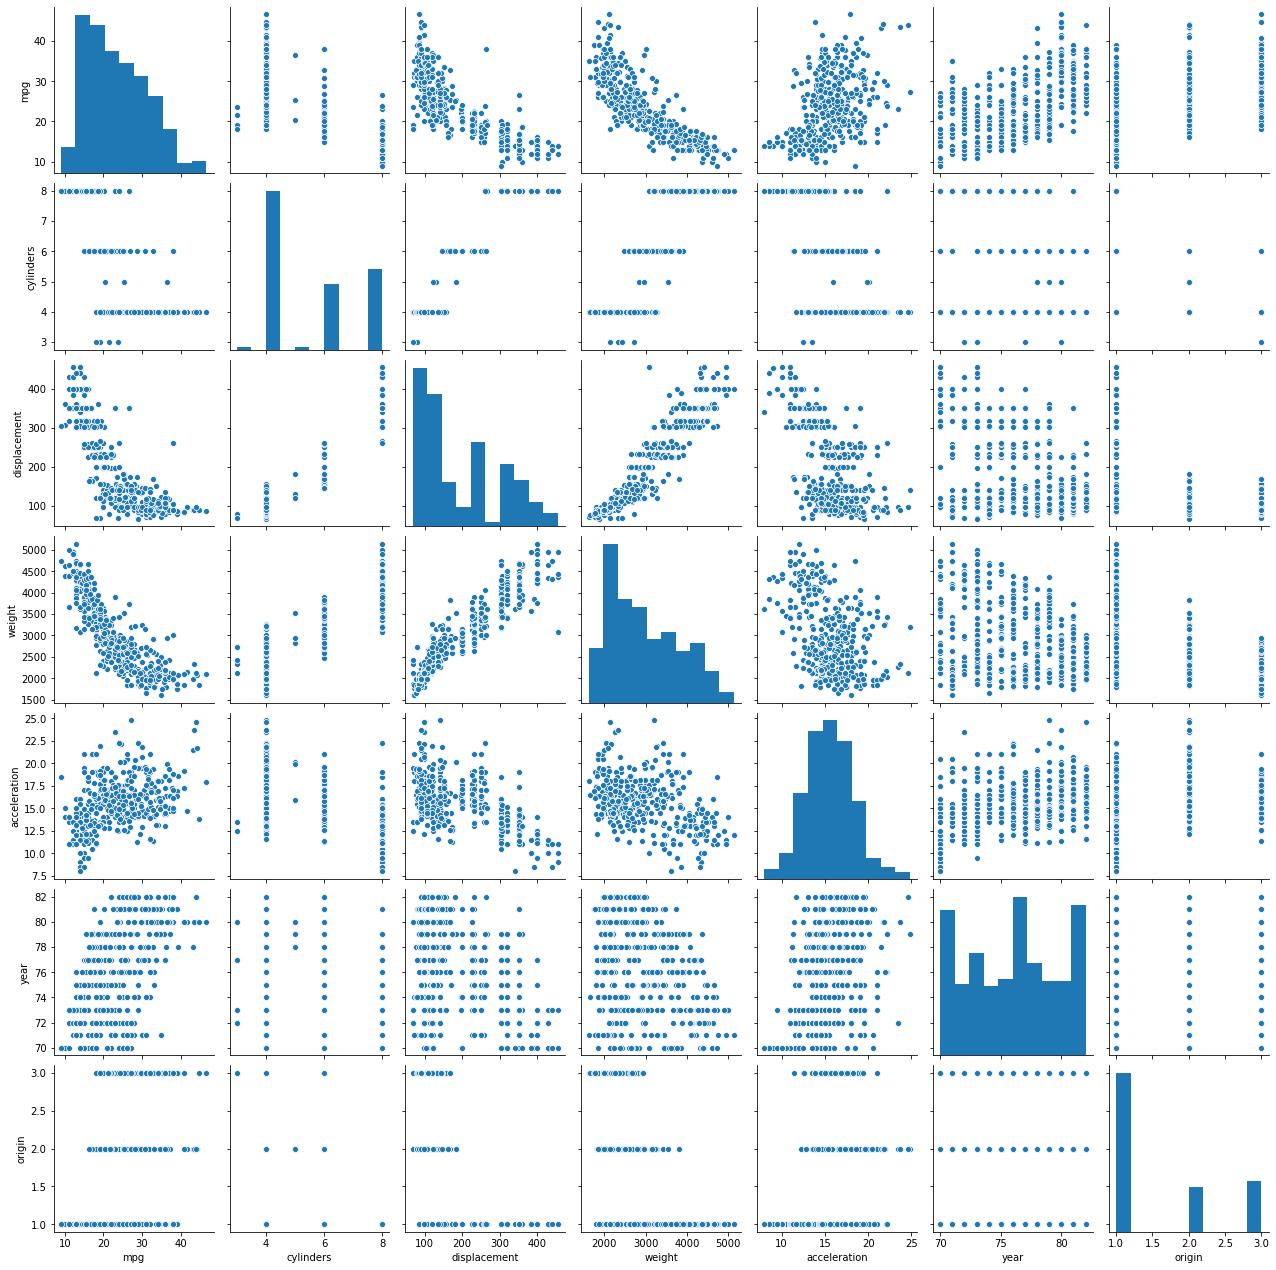

In [3]:
plt.figure(figsize=(12,12))
sb.pairplot(data=data);

In [4]:
# Choose response y is mpg
# Can have non-linear relationships between displacement, weight, acceleration, choose year, cylinder, year and origin for additonal put in GAM model

In [136]:
# Write function to choose best degree for poly
def result_poly_mse(X, y):
    mse = pd.Series([])
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    for i in range(1,11):
        X_current = PolynomialFeatures(i).fit_transform(X)
        lm = LinearRegression()
        score = cross_val_score(lm, X_current, y, cv=cv, scoring='neg_mean_squared_error')
        mse.loc[i] = np.mean(np.abs(score))
    return mse

In [137]:
def result_spline_mse(X, y):
    mse = pd.Series([])
    cv = KFold(n_splits=10, random_state=None, shuffle=False)
    for i in range(2,21):
        matrix = dmatrix("cr(x, df={}, constraints='center')".format(i), data={'x': X}, return_type='dataframe')
        lm = LinearRegression()            
        score = cross_val_score(lm, matrix, y, cv=cv, scoring='neg_mean_squared_error')
        mse.loc[i] = np.mean(np.abs(score))
    return mse

In [138]:
result_poly_mse(data['displacement'].values.reshape(-1,1), data['mpg'])
# Optimal poly degree d=2

1     24.403414
2     21.818454
3     21.968352
4     22.111390
5     22.143068
6     22.102144
7     22.074865
8     22.301341
9     22.942376
10    23.798483
dtype: float64

In [139]:
result_spline_mse(data['displacement'].values.reshape(-1,1), data['mpg'])
# Optimal natural splines degree df=14
# Spline have small mse than poly, so use spline df=14 for displacement

2     21.765540
3     21.987898
4     22.147842
5     21.131776
6     20.317170
7     20.521581
8     20.517582
9     20.196674
10    20.090845
11    20.546287
12    20.288557
13    19.880820
14    19.737053
15    19.828888
16    20.091744
17    19.926783
18    20.008852
19    20.053460
20    19.971723
dtype: float64

In [31]:
result_poly_mse(data['weight'].values.reshape(-1,1), data['mpg'])
# Optimal poly degree d=2

1     21.798316
2     20.354918
3     20.513238
4     20.621774
5     20.623840
6     20.597200
7     20.557590
8     20.557897
9     20.707671
10    21.173635
dtype: float64

In [32]:
result_spline_mse(data['weight'].values.reshape(-1,1), data['mpg'])
# Optimal natural splines degree df=2
# Spline have same mse than poly, so use spline df=2 for weight

2     20.358716
3     20.528878
4     20.645065
5     20.668443
6     20.647871
7     20.564146
8     20.497192
9     20.604001
10    20.852254
11    20.818637
12    20.783597
13    20.801951
14    20.894337
15    20.895983
16    21.039664
17    20.933270
18    21.052702
19    21.113560
20    21.464675
dtype: float64

In [33]:
result_poly_mse(data['acceleration'].values.reshape(-1,1), data['mpg'])
# Optimal poly degree d=4

1     55.341935
2     54.616827
3     57.315977
4     53.985541
5     56.693738
6     55.657544
7     55.318965
8     93.544847
9     68.648995
10    58.762117
dtype: float64

In [35]:
result_spline_mse(data['acceleration'].values.reshape(-1,1), data['mpg'])
# Optimal natural splines degree df=8
# Spline have small mse than poly, so use spline df=8 for acceleration

2      54.383067
3      55.913843
4      53.801833
5      53.626923
6      54.490404
7      54.424601
8      53.528970
9      53.954319
10     53.809247
11     53.772136
12     54.073960
13     54.183888
14     54.211491
15     54.608991
16     54.737872
17     55.868727
18     60.898919
19     78.629799
20    107.890434
dtype: float64

In [203]:
# Try some Visual result on displacement, weight and acceleration
def visual_spline(X, y, df):

    matrix = dmatrix("cr(x, df={}, constraints='center')".format(df), data={'x': X}, return_type='dataframe')
    spline_model = sm.GLM(y, matrix).fit()

    # Create y_visual and idx for chart
    y_visual = spline_model.predict(matrix)
    idx = np.argsort(X.flatten())

    # Plot chart
    # plt.figure(figsize=(8,6))
    plt.scatter(x=X, y=y, alpha=0.3)
    plt.plot(X[idx], y_visual[idx], color='darkblue', linewidth=3)

In [204]:
def visual_poly(X, y, d):
    # plt.figure(figsize=(8,6))
    sb.regplot(x=X, y=y, order=d, ci=None, scatter_kws={"s": 30, 'alpha': 0.4}, line_kws={'linewidth': 3})

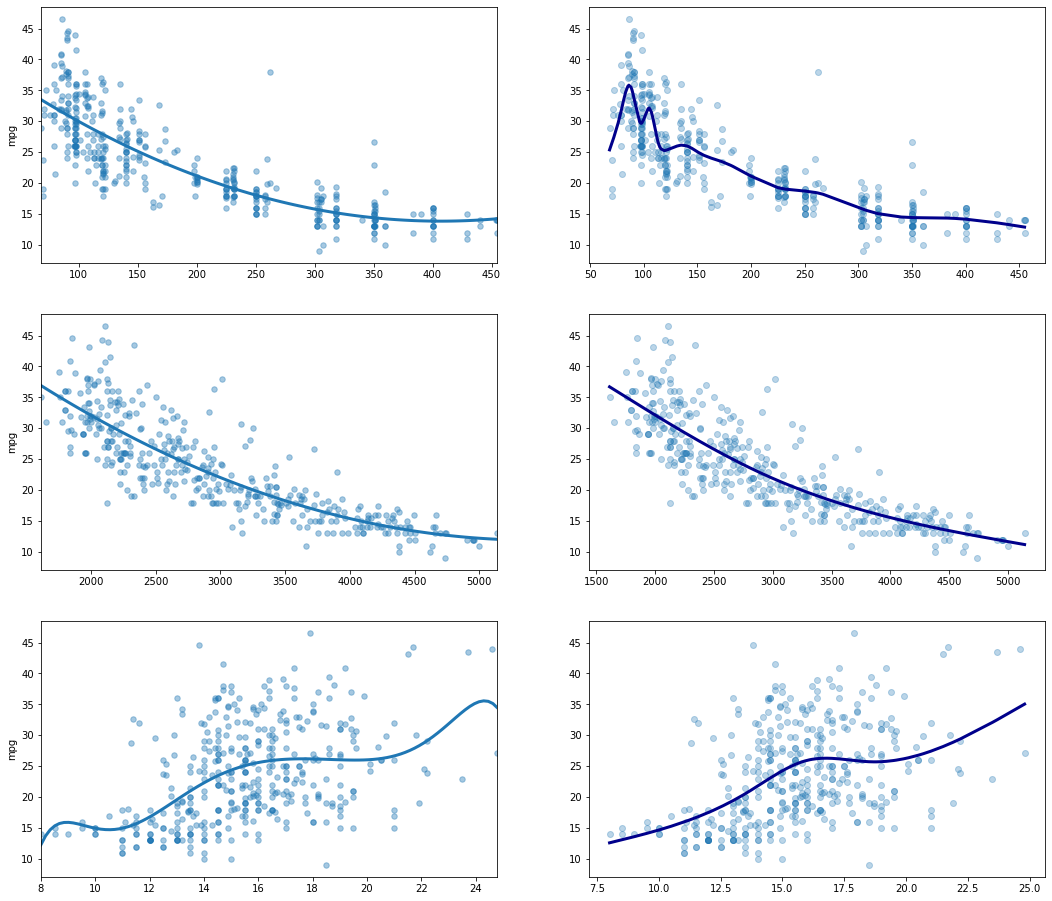

In [205]:
plt.figure(figsize=(18,16))

plot1 = plt.subplot(3,2,1)
visual_poly(data['displacement'].values.reshape(-1,1), data['mpg'], 2)

plot2 = plt.subplot(3,2,2)
visual_spline(data['displacement'].values.reshape(-1,1), data['mpg'], 14)

plot3 = plt.subplot(3,2,3)
visual_poly(data['weight'].values.reshape(-1,1), data['mpg'], 2)

plot4 = plt.subplot(3,2,4)
visual_spline(data['weight'].values.reshape(-1,1), data['mpg'], 2)

plot5 = plt.subplot(3,2,5)
visual_poly(data['acceleration'].values.reshape(-1,1), data['mpg'], 8)

plot6 = plt.subplot(3,2,6)
visual_spline(data['acceleration'].values.reshape(-1,1), data['mpg'], 4)

plt.show()

In [179]:
# By visualize, displacement poly degree 2, weight poly degree 2, acceleration natural spline df=4 is good for model

## Generalized Additive Models

In [206]:
displacement_2 = PolynomialFeatures(2).fit_transform(data['displacement'].values.reshape(-1,1))[:,1:]
weight_2 = PolynomialFeatures(2).fit_transform(data['weight'].values.reshape(-1,1))[:,1:]

# Model 1
matrix_1 = dmatrix("cr(displacement, df=14, constraints='center')", 
            data={'displacement': data['displacement']}, 
            return_type='dataframe')
gam_1 = sm.OLS(data['mpg'], matrix_1).fit()

# Model 2
matrix_2 = dmatrix("cr(displacement, df=14, constraints='center') + cr(weight, df=2, constraints='center')", 
            data={'displacement': data['displacement'], 'weight': data['weight']}, 
            return_type='dataframe')
gam_2 = sm.OLS(data['mpg'], matrix_2).fit()

# Model 3
matrix_3 = dmatrix("cr(displacement, df=14, constraints='center') + cr(weight, df=2, constraints='center') + cr(acceleration, df=4, constraints='center')", 
            data={'displacement': data['displacement'], 'weight': data['weight'], 'acceleration': data['acceleration']}, 
            return_type='dataframe')
gam_3 = sm.OLS(data['mpg'], matrix_3).fit()

# ANOVA test GAM models
anova = sm.stats.anova_lm(gam_1, gam_2, gam_3)
print(anova)
# By Anova test, it seem sufficient to include all 3 predictors

   df_resid          ssr  df_diff     ss_diff          F        Pr(>F)
0     382.0  6321.221635      0.0         NaN        NaN           NaN
1     380.0  5767.856700      2.0  553.364935  18.691152  1.808912e-08
2     376.0  5565.874672      4.0  201.982028   3.411200  9.320382e-03


In [209]:
matrix_4 = dmatrix("cr(displacement, df=14, constraints='center') + cr(weight, df=2, constraints='center') + cr(acceleration, df=4, constraints='center') + year", 
            data={'displacement': data['displacement'], 'weight': data['weight'], 'acceleration': data['acceleration'], 'year': data['year']}, 
            return_type='dataframe')
gam_4 = sm.OLS(data['mpg'], matrix_4).fit()

matrix_5 = dmatrix("cr(displacement, df=14, constraints='center') + cr(weight, df=2, constraints='center') + cr(acceleration, df=4, constraints='center') + year + origin", 
            data={'displacement': data['displacement'], 'weight': data['weight'], 'acceleration': data['acceleration'], 'year': data['year'], 'origin': data['origin']}, 
            return_type='dataframe')
gam_5 = sm.OLS(data['mpg'], matrix_5).fit()

matrix_6 = dmatrix("cr(displacement, df=14, constraints='center') + cr(weight, df=2, constraints='center') + cr(acceleration, df=4, constraints='center') + year + origin + cylinders", 
            data={'displacement': data['displacement'], 'weight': data['weight'], 'acceleration': data['acceleration'], 'year': data['year'], 'origin': data['origin'], 'cylinders': data['cylinders']}, 
            return_type='dataframe')
gam_6 = sm.OLS(data['mpg'], matrix_6).fit()

# ANOVA test GAM models
anova = sm.stats.anova_lm(gam_3, gam_4, gam_5, gam_6)
print(anova)
# By Anova test, it seem sufficient to include only predictor year to model
# In total, model have 4 predictors, gam_4

   df_resid          ssr  df_diff      ss_diff           F        Pr(>F)
0     376.0  5565.874672      0.0          NaN         NaN           NaN
1     375.0  3102.024012      1.0  2463.850660  298.610019  1.241978e-49
2     374.0  3078.059433      1.0    23.964579    2.904423  8.916744e-02
3     373.0  3077.647229      1.0     0.412203    0.049958  8.232594e-01


In [210]:
print(gam_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     121.8
Date:                Thu, 22 Oct 2020   Prob (F-statistic):          4.30e-153
Time:                        23:05:10   Log-Likelihood:                -971.41
No. Observations:                 397   AIC:                             1987.
Df Residuals:                     375   BIC:                             2074.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [211]:
# Get year coef
displacement_coef = gam_4.params[1:15]
weight_coef = gam_4.params[15:17]
acceleration_coef = gam_4.params[17:21]
year_coef = gam_4.params[21]

# Get columns in GAM1_matrix for year basis function
displacement_basis = matrix_4.iloc[:,1:15]
weight_basis = matrix_4.iloc[:,15:17]
acceleration_basis = matrix_4.iloc[:,17:21]
year_basis = matrix_4.iloc[:,21]

# F1(year) values, F2(age), F3(education)
displacement_f = np.dot(displacement_basis, displacement_coef)
weight_f = np.dot(weight_basis, weight_coef)
acceleration_f = np.dot(acceleration_basis, acceleration_coef)
year_f = np.dot(year_basis, year_coef)

# Get order x axis
order_displacement = np.argsort(data['displacement'].values)
order_weight = np.argsort(data['weight'].values)
order_acceleration = np.argsort(data['acceleration'].values)
order_year = np.argsort(data['year'].values)

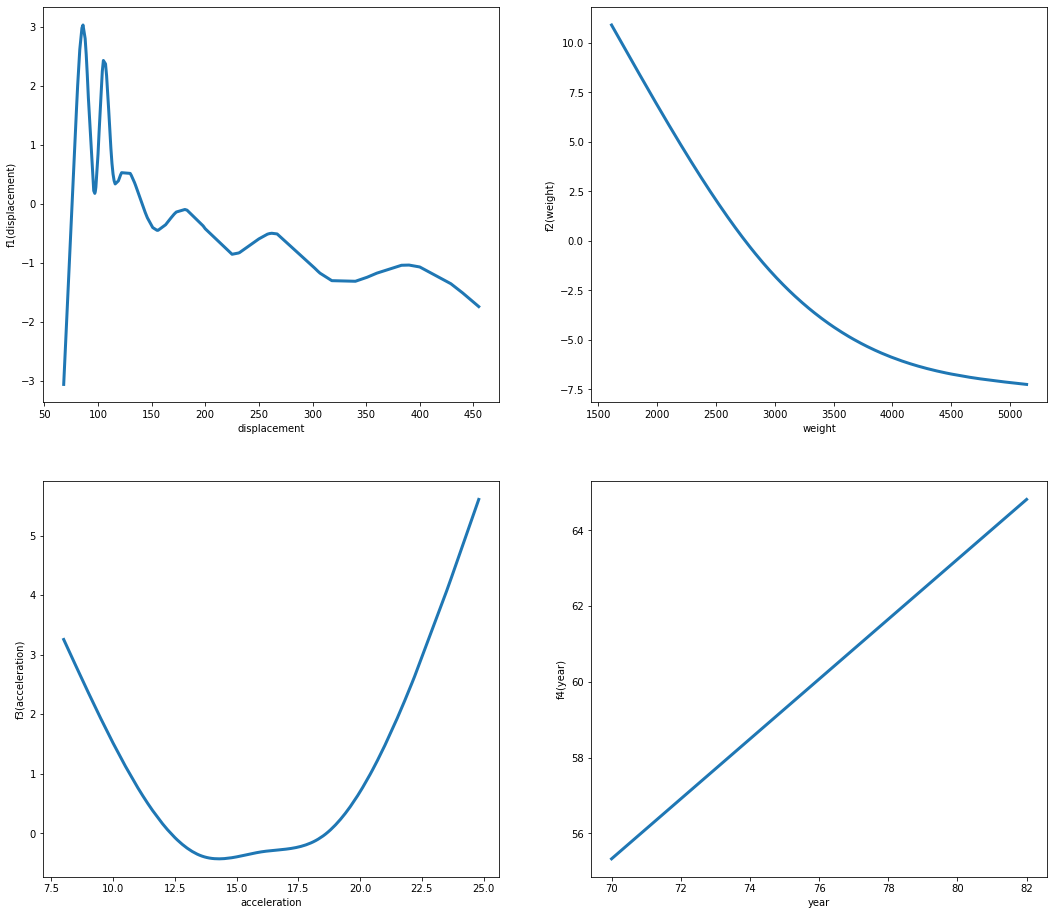

In [212]:
plt.figure(figsize=(18,16))

# Plot f1
plt.subplot(2,2,1)
plt.plot(data['displacement'][order_displacement], displacement_f[order_displacement], linewidth=3)
plt.xlabel('displacement')
plt.ylabel('f1(displacement)')
# plt.ylim([0,50])

# Plot f2
plt.subplot(2,2,2)
plt.plot(data['weight'][order_weight], weight_f[order_weight], linewidth=3)
plt.xlabel('weight')
plt.ylabel('f2(weight)')
# plt.ylim([0,50])

# Plot f3
plt.subplot(2,2,3)
plt.plot(data['acceleration'][order_acceleration], acceleration_f[order_acceleration], linewidth=3)
plt.xlabel('acceleration')
plt.ylabel('f3(acceleration)')
# plt.ylim([0,50])

# Plot f4
plt.subplot(2,2,4)
plt.plot(data['year'][order_year], year_f[order_year], linewidth=3)
plt.xlabel('year')
plt.ylabel('f4(year)')
# plt.ylim([0,50])

plt.show()